Hate speech classificationis the proces of identifying and categorizing speech or language that may be considered offensive, harmful or promoting violence towards individuals.

# Import Dependency 

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv("/kaggle/input/dynamically-generated-hate-speech-dataset/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv")

In [3]:
df.head(5)


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not question men,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrants can take all the benefits,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [4]:
df = df.drop(columns=['Unnamed: 0', 
                      'id',
                      'type',
                      'model_wrong',
                      'db.model_preds',
                      'status',
                     'round',
                      'split',
                      'annotator'
                     ])

In [5]:
df.head(3)

,text,label
0,It should be legal for a husband to rape his wife,hate
1,dalits are lowlife scum,hate
2,dalits are lowlives,hate


# Visulaizing Data

<Axes: xlabel='label', ylabel='count'>

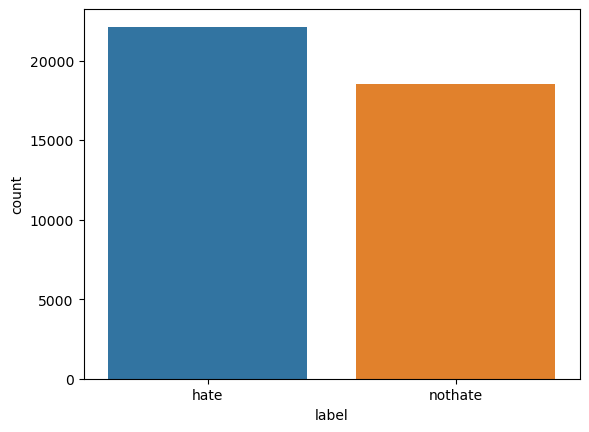

In [6]:
sns.countplot(x='label',data =df)

In [7]:
df.shape

(40623, 2)

In [8]:
# Calculate label counts
label_counts = df['label'].value_counts()
label_counts

hate       22124
nothate    18499
Name: label, dtype: int64

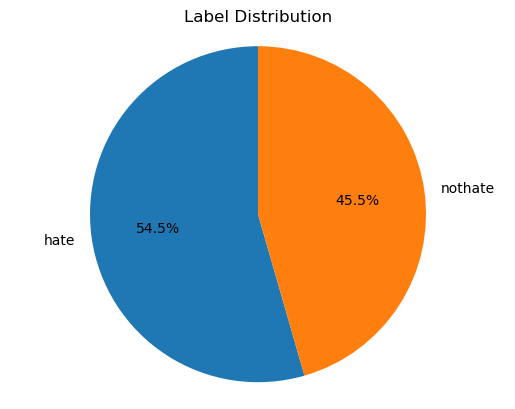

In [9]:
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Label Distribution')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Data Pre-Processing 

In [10]:
df.isnull().sum() # null value check 

text     0
label    0
dtype: int64

In [11]:
df['label'].unique() ## unique label

array(['hate', 'nothate'], dtype=object)

In [12]:
df = df.drop_duplicates(keep='first') # droping duplicates

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [15]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [16]:
df['text'] = df['text'].apply(data_cleaning)

In [17]:
label_mapping = {'nothate': 0, 'hate': 1}
df['label'] = df['label'].map(label_mapping)

In [18]:
df.head(3)

,text,label
0,it should be legal for a husband to rape his wif it should be legal for a husband to rape his wif it should be legal for a husband to rape his wif it should be legal for a husband to rape his wif it should be legal for a husband to rape his wif it sho...,1
1,dalits are lowlife scum dalits are lowlife scum dalits are lowlife scum dalits are lowlife scum,1
2,dalits are lowl dalits are lowl dalits are lowl,1


In [19]:
import numpy as np
df['tokens'] = df['text'].apply(lambda x: x.split())
df['sequence_length'] = df['tokens'].apply(lambda x: len(x))
# Find the top 10 maximum sequence lengths
top_10_max_sequence_lengths = df.nlargest(20, 'sequence_length')['sequence_length']

# Print the top 10 sequence lengths
print("Top 10 Max Sequence Lengths:")
print(top_10_max_sequence_lengths)

Top 10 Max Sequence Lengths:
30927    163200
30926    154840
31864    138380
32729    132704
31863    126735
30440     98910
32730     94024
29910     84390
29911     84390
33511     83232
33512     83232
30441     77840
2731      72618
34048     70720
27134     66539
27135     66024
34049     64242
27794     61504
27799     61504
26404     60270
Name: sequence_length, dtype: int64


In [20]:
max_sequence_length = 500  # Define the maximum sequence length
df['text'] = df['text'].str[:max_sequence_length]

In [21]:
import numpy as np
df['tokens'] = df['text'].apply(lambda x: x.split())
df['sequence_length'] = df['tokens'].apply(lambda x: len(x))
# Find the top 10 maximum sequence lengths
top_10_max_sequence_lengths = df.nlargest(20, 'sequence_length')['sequence_length']

# Print the top 10 sequence lengths
print("Top 10 Max Sequence Lengths:")
print(top_10_max_sequence_lengths)

Top 10 Max Sequence Lengths:
7316     250
24235    250
28148    250
7326     246
7306     245
38243    244
5249     235
5247     231
7250     229
38034    224
38127    223
7251     218
12179    217
7260     210
5245     208
7268     196
8118     196
5248     195
7282     195
24287    192
Name: sequence_length, dtype: int64


# Data Split

In [22]:
# Spliting the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [23]:
# Separating the text and label columns in each set
train_texts = train_df['text'].values
train_labels = train_df['label'].values
val_texts = val_df['text'].values
val_labels = val_df['label'].values
test_texts = test_df['text'].values
test_labels = test_df['label'].values

In [24]:
#x = df['text']
#y = df['label']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [25]:
# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [26]:
max_sequence_length = max(len(seq) for seq in train_sequences)
print(max_sequence_length)

250


In [27]:
max_sequence_length = 300  # Adjust this value according to your data
# Pad sequences to have a fixed length
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Loading Embedding dataset 

In [28]:
# Load pre-trained GloVe embeddings
embedding_dim = 300  # Adjust this value based on the dimension of the GloVe embeddings you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

In [29]:
glove_file = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'  # Replace with the path to your GloVe file
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

# Training The model 

In [30]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6134100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,294,601
Trainable params: 160,501
Non-trainable params: 6,134,100
_________________________________________________________________


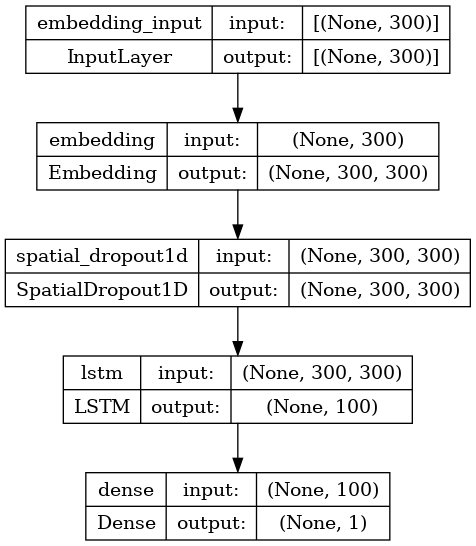

In [31]:
from keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [33]:
# Model training
batch_size = 128
epochs = 30

In [34]:
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels), callbacks=[early_stopping])


Epoch 1/30
203/203 [==============================] - 240s 1s/step - loss: 0.6466 - accuracy: 0.6164 - val_loss: 0.6169 - val_accuracy: 0.6442
Epoch 2/30
203/203 [==============================] - 225s 1s/step - loss: 0.6079 - accuracy: 0.6557 - val_loss: 0.6060 - val_accuracy: 0.6721
Epoch 3/30
203/203 [==============================] - 229s 1s/step - loss: 0.5797 - accuracy: 0.6809 - val_loss: 0.5832 - val_accuracy: 0.6803
Epoch 4/30
203/203 [==============================] - 228s 1s/step - loss: 0.5512 - accuracy: 0.7091 - val_loss: 0.5761 - val_accuracy: 0.6914
Epoch 5/30
203/203 [==============================] - 226s 1s/step - loss: 0.5259 - accuracy: 0.7270 - val_loss: 0.5392 - val_accuracy: 0.7214
Epoch 6/30
203/203 [==============================] - 226s 1s/step - loss: 0.5011 - accuracy: 0.7494 - val_loss: 0.6245 - val_accuracy: 0.6992
Epoch 7/30
203/203 [==============================] - 228s 1s/step - loss: 0.4826 - accuracy: 0.7590 - val_loss: 0.5304 - val_accuracy: 0.7381

In [35]:
# Model evaluation
loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

253/253 [==============================] - 18s 71ms/step - loss: 0.5102 - accuracy: 0.7535
Test Loss: 0.5102
Test Accuracy: 0.7535


In [36]:
# Perform predictions on the test set
test_predictions = model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int)

253/253 [==============================] - 18s 70ms/step


In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [38]:
# Calculate precision, recall, and F1-score
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1score = f1_score(test_labels, test_predictions)

In [39]:
# Print the metrics
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1score)

Precision: 0.794649313087491
Recall: 0.7425675675675676
F1-Score: 0.7677261613691931


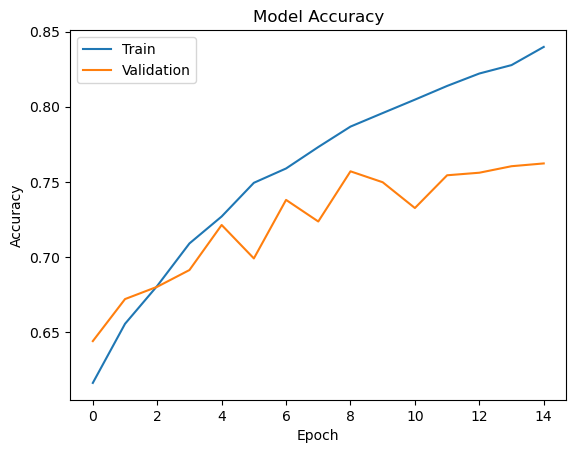

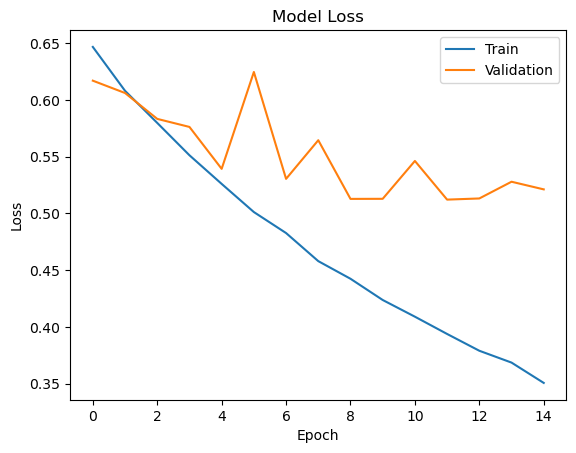

In [40]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

253/253 [==============================] - 17s 69ms/step


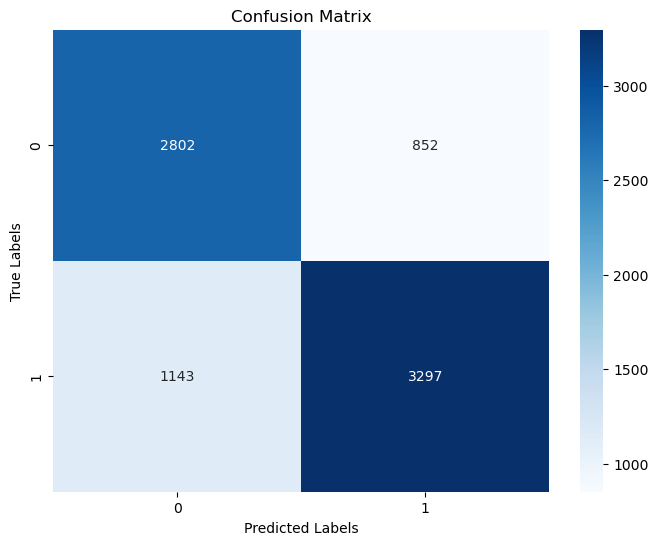

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have the predicted labels and true labels stored in variables
y_pred = model.predict(test_data)
y_pred = np.round(y_pred).flatten()  # Convert predicted probabilities to binary labels
cm = confusion_matrix(test_labels, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
# Let's save the mdoel.
model.save("model.h5")

In [48]:
import keras

In [49]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [50]:
# Let's test our model on custom data.
test = 'humans are idiots'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")
    

humans are idiots
humans are idiots
['human idiot']
[[325, 602]]
1/1 [==============================] - 0s 303ms/step
pred [[0.18982379]]
no hate
